In [31]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from IPython import display
from collections import Counter
import optuna
import wandb
from tqdm import tqdm
from gymnasium.envs.toy_text.frozen_lake import generate_random_map

In [32]:
# Environment setup
env = gym.make('FrozenLake-v1', is_slippery=False)
n_actions = env.action_space.n
n_states = env.observation_space.n

In [33]:
# Neural network model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc = nn.Linear(n_states, n_actions)

    def forward(self, x):
        return self.fc(x)
    
class ConvNet(nn.Module):
    def __init__(self, input_size, n_actions, dropout_p=None):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(4, 16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        # 1x1 conv for matching dimensions in residual connection
        self.match_channels1 = nn.Conv2d(4, 16, kernel_size=1, stride=1, padding=0)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        # 1x1 conv for matching dimensions in residual connection
        self.match_channels2 = nn.Conv2d(16, 32, kernel_size=1, stride=1, padding=0)

        self.fc = nn.Linear(32 * input_size, n_actions)
        self.dropout_p = dropout_p
        if dropout_p is not None:
            self.dropout = nn.Dropout(dropout_p)

    def forward(self, x):
        # First convolutional block with residual connection
        residual = self.match_channels1(x)
        out = F.relu(self.bn1(self.conv1(x)))
        x = out + residual

        # Second convolutional block with residual connection
        residual = self.match_channels2(x)
        out = F.relu(self.bn2(self.conv2(x)))
        x = out + residual

        # Flattening and passing through fully connected layer
        x = x.view(x.size(0), -1)
        if self.dropout_p is not None:
            x = self.dropout(x)
        return self.fc(x)

In [ ]:
def actions_from_q_values(q_values, epsilon):
    """
    Selects actions according to epsilon-greedy policy.
    """
    if random.random() < epsilon:
        return random.randint(0, n_actions - 1)
    else:
        # Apply softmax to convert q_values into probabilities
        probabilities = torch.nn.functional.softmax(q_values, dim=1)
        
        # Sample actions based on the probabilities
        actions = np.array([torch.multinomial(p, 1).item() for p in probabilities]).cpu().numpy()
        return actions


In [34]:
device = torch.device("mps")

In [35]:
def preprocess_state(position, map_layout):
    nrows, ncols = 4, 4  # Assuming a 4x4 map
    num_statuses = 4      # Four statuses including the agent's position

    # Initialize a 4x4x4 tensor for one-hot encoded state
    state_tensor = np.zeros((nrows, ncols, num_statuses))

    # Decode map layout
    layout_to_val = {b'F': 0, b'H': 1, b'S': 0, b'G': 3}  # Start 'S' also considered safe '0'

    for i in range(nrows):
        for j in range(ncols):
            # Set the appropriate index in the one-hot vector
            state_tensor[i, j, layout_to_val[map_layout[i][j]]] = 1

    # Convert position to 2D coordinates and update in state tensor
    row, col = divmod(position, ncols)
    # Resetting the cell to a blank state before marking the current position
    state_tensor[row, col] = np.array([0, 0, 0, 0])
    state_tensor[row, col, 2] = 1  # Marking the current position with one-hot encoding

    return torch.tensor(state_tensor, dtype=torch.float)


In [36]:
print(env.desc)

[[b'S' b'F' b'F' b'F']
 [b'F' b'H' b'F' b'H']
 [b'F' b'F' b'F' b'H']
 [b'H' b'F' b'F' b'G']]


In [37]:
def calculate_intermediate_reward(current_state, next_state, env, visited_states, forward_step_reward=0, visited_step_reward=0, in_place_reward=0):
    """
    Calculate intermediate reward based on movement towards the goal.
    """
    if next_state == current_state:
        return in_place_reward
    elif next_state in visited_states:
        return visited_step_reward 
    else:
        return forward_step_reward if next_state > current_state else 0


def create_vectorized_environments(env_name, n_envs, random_map, is_slippery):
    if random_map:
        envs = [gym.make(env_name, desc=generate_random_map(size=4), is_slippery=is_slippery) for _ in range(n_envs)]
    else:
        envs = [gym.make(env_name, is_slippery=is_slippery) for _ in range(n_envs)]
    return envs

# Training Function
def train_model(model, optimizer, loss_fn, gamma, epsilon_start, epsilon_decay, num_episodes, device, n_states, random_map=False, is_slippery=False, hole_reward=0, forward_step_reward=0, visited_step_reward=0, in_place_reward=0):
    n_envs = 8
    max_steps = 4 * 4 * 4 # 4x the number of states seems like a reasonable upper bound
    epsilon = epsilon_start

    last_eval_success_rate = 0 # metric that is sparsely updated
    weight_norm = sum(torch.norm(param)**2 for param in model.parameters() if param.dim() > 1)
    bias_norm = sum(torch.norm(param)**2 for param in model.parameters() if param.dim() == 1)


    plot_update_frequency = int(num_episodes * (5/100))  # update plots every 5% of episodes
    if plot_update_frequency == 0:
        plot_update_frequency = 1


    # Training loop
    for episode in tqdm(range(num_episodes)):
        model.train()
        # Create vectorized environments
        envs = create_vectorized_environments('FrozenLake-v1', n_envs, random_map, is_slippery)


        states = [env.reset()[0] for env in envs]
        dones = [False] * n_envs
        episode_rewards = [0] * n_envs
        visited_states = [set() for _ in envs]

        step_count = 0
        ongoing_indices = list(range(n_envs))  # Initialize with all environment indices

        # TODO: fix loss bug when len is 1
        while len(ongoing_indices) > 1 and step_count < max_steps:
            step_count += 1
            # Filter out completed environments for action selection and state update
            ongoing_envs = [envs[i] for i in ongoing_indices]
            ongoing_states = [states[i] for i in ongoing_indices]


            # Preprocess all states and convert them into tensors
            state_tensors = [preprocess_state(state, env.desc).to(device) for state, env in zip(ongoing_states, ongoing_envs)] 
            # Combine all state tensors into a single batch
            state_tensor_batch = torch.stack(state_tensors)
            
            # Compute Q-values for the entire batch
            q_values_batch = model(state_tensor_batch)
            
            # Iterate over each environment to select actions
            actions = []
            for i, (q_values, env) in enumerate(zip(q_values_batch, ongoing_envs)):
                visited_states[ongoing_indices[i]].add(states[ongoing_indices[i]])
            
                if random.random() < epsilon:
                    action = env.action_space.sample()
                else:
                    action = torch.argmax(q_values).item()
            
                actions.append(action)


            next_states, rewards, next_dones = [], [], []
            for i, (env, action) in enumerate(zip(ongoing_envs, actions)):
                next_state, reward, done, _, _ = env.step(action)
                # Custom reward logic
                if done and reward == 0:  # Agent fell into a hole
                    reward = hole_reward
                else:
                    # Additional logic to calculate reward for moving towards the goal
                    reward += calculate_intermediate_reward(states[ongoing_indices[i]], next_state, env, visited_states, forward_step_reward, visited_step_reward, in_place_reward)

                next_states.append(next_state)
                rewards.append(reward)
                next_dones.append(done)
                episode_rewards[ongoing_indices[i]] += reward
            
            
            next_states_tensors = [preprocess_state(state, env.desc).to(device) for state, env in zip(next_states, ongoing_envs)]
            next_states_batch = torch.stack(next_states_tensors)
                        # Create batches for rewards, actions, and dones
            reward_batch = torch.tensor(rewards, device=device)
            action_batch = torch.tensor(actions, device=device)
            done_batch = torch.tensor(next_dones, device=device)
            
            # Compute Q-values for the entire batch
            next_q_values_batch = model(next_states_batch)
            max_next_state_q_values = torch.max(next_q_values_batch, dim=1)[0]
            # Compute the target Q-values
            target_q_values = reward_batch + gamma * max_next_state_q_values * (1 - done_batch.float())
            #print(q_values_batch.shape) # (8, 4)
            #print(action_batch.shape) # (8,)
            #print(target_q_values.shape) # (8,)
            # Correct way to get predicted Q values for the taken actions
            predicted_q_values = q_values_batch.gather(1, action_batch.unsqueeze(-1)).squeeze()
            # Compute the loss
            loss = loss_fn(predicted_q_values, target_q_values)
            
            # Rest of your optimization logic
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=10.0)
            optimizer.step()

            # Update states of ongoing indices
            for i, (next_state, done) in enumerate(zip(next_states, next_dones)):
                if not done:
                    states[ongoing_indices[i]] = next_state


            grad_norm = sum(torch.norm(param.grad)**2 for param in model.parameters() if param.grad is not None)
            # log metrics to wandb
            wandb.log({"loss": loss.item(),
                       "weight_norm": weight_norm.item(),
                       "bias_norm": bias_norm.item(),
                       "grad_norm": grad_norm.item(),
                       "epsilon": epsilon,
                       "average_episode_rewards": sum(episode_rewards)/len(episode_rewards),
                       "last_eval_success_rate": last_eval_success_rate})
            

            # Update ongoing indices
            new_ongoing_indices = []
            for i, (done, reward) in enumerate(zip(next_dones, rewards)):
                if not done:
                    new_ongoing_indices.append(ongoing_indices[i])
            ongoing_indices = new_ongoing_indices
        # Close all environments at the end of the episode
        for env in envs:
            env.close()
    

        # Decay epsilon
        if epsilon > 0.01:
            epsilon *= epsilon_decay

        if episode % plot_update_frequency == 0 or episode == num_episodes - 1:
            # update some metrics  
            last_eval_success_rate = evaluate_model(model, 100, device, n_states, n_envs, is_slippery, random_map)
            weight_norm = sum(torch.norm(param)**2 for param in model.parameters() if param.dim() > 1)
            bias_norm = sum(torch.norm(param)**2 for param in model.parameters() if param.dim() == 1) 

    return model

In [38]:
def evaluate_model(model, num_eval_episodes, device, n_states, batch_size=10, is_slippery=False, random_map=False):
    #TODO: give other metrics such as average episode length, average reward, etc.
    model.eval()
    with torch.no_grad():
        successful_episodes = 0
        total_evaluated = 0
    
        while total_evaluated < num_eval_episodes:
            envs = []
            states = []
            dones = []
            for _ in range(min(batch_size, num_eval_episodes - total_evaluated)):
                if random_map:
                    env = gym.make('FrozenLake-v1', desc=generate_random_map(size=4), is_slippery=is_slippery)
                else:
                    env = gym.make('FrozenLake-v1', is_slippery=is_slippery)
                envs.append(env)
                states.append(env.reset()[0])
                dones.append(False)
    
            max_steps = len(envs[0].desc) * len(envs[0].desc[0]) * 4
            step_count = 0
    
            while step_count < max_steps and not all(dones):
                step_count += 1
                state_tensors = [preprocess_state(state, env.desc).to(device) for state, env in zip(states, envs)]
                state_batch = torch.stack(state_tensors)
                q_values = model(state_batch)
                actions = torch.argmax(q_values, dim=1).cpu().numpy()
    
                for i, env in enumerate(envs):
                    if not dones[i]:
                        next_state, reward, done, _, _ = env.step(actions[i])
                        states[i] = next_state
                        dones[i] = done
    
                        if done and reward > 0:
                            successful_episodes += 1
    
            total_evaluated += len(envs)
    
        success_rate = successful_episodes / num_eval_episodes
    return success_rate


In [39]:
# Optuna Objective Function
def objective(trial):
    wandb.init(project="frozenlake_slipperry_optuna_reward_search_convnet_random_map",
               name=f"trial_{trial.number}",
               config=trial.params,
               reinit=True)
    # find rewards
    hole_reward = trial.suggest_float("hole_reward", -1, 0)
    forward_step_reward = trial.suggest_float("forward_step_reward", 0, 1)
    visited_step_reward = trial.suggest_float("visited_step_reward", -1, 0)
    
    # Hyperparameters
    learning_rate = 0.0001
    gamma = 0.99
    epsilon = 0.8
    epsilon_decay = 0.999
    num_episodes = 2500

    n_actions = env.action_space.n
    n_states = env.observation_space.n
    model = ConvNet(n_states, n_actions).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    loss_fn = nn.MSELoss().to(device)
    random_map = True
    is_slippery = False

    trained_model = train_model(model, optimizer, loss_fn, gamma, epsilon, epsilon_decay, num_episodes, device, n_states, random_map=random_map, is_slippery=is_slippery,
                                hole_reward=hole_reward, forward_step_reward=forward_step_reward, visited_step_reward=visited_step_reward)
    
    num_eval_episodes = 50 
    success_rate = evaluate_model(trained_model, num_eval_episodes, device, n_states, is_slippery, random_map)


    wandb.finish()
    return success_rate


study

In [40]:
"""
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print("Best trial:")
trial = study.best_trial
print(f" Value: {trial.value}")
print(" Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")
"""

'\nstudy = optuna.create_study(direction=\'maximize\')\nstudy.optimize(objective, n_trials=50)\n\nprint("Best trial:")\ntrial = study.best_trial\nprint(f" Value: {trial.value}")\nprint(" Params: ")\nfor key, value in trial.params.items():\n    print(f"    {key}: {value}")\n'

In [41]:
# Hyperparameters
learning_rate = 0.0001
gamma = 0.99
epsilon = 0#0.8
epsilon_decay = 0.999
weight_decay = 1e-5
dropout_p = 0.5

In [42]:
random_map = True
is_slippery = False

In [43]:
# Train the model
num_episodes = 3000
n_actions = env.action_space.n
n_states = env.observation_space.n
model = ConvNet(n_states, n_actions, dropout_p=dropout_p).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
loss_fn = nn.MSELoss()
wandb.init(project="frozenlake_slipperry_batches_convnet_random_map",
           name=f"Batch normalization 3000 steps, Trying sparse rewards with epsilon, 0.8 epsilon + decay 0.999, 0.99 gamma, Residual + dropout 0.5, weight decay 1e-5, random map",
           reinit=True)
model = train_model(model, optimizer, loss_fn, gamma, epsilon, epsilon_decay, num_episodes, device, n_states, 
                    random_map=random_map, is_slippery=is_slippery,
                    forward_step_reward=0.2,
                    visited_step_reward=0,
                    hole_reward=-0.1,
                    in_place_reward=-0.05)
wandb.finish()

100%|██████████| 3000/3000 [29:11<00:00,  1.71it/s] 


average_episode_rewards,▁▁▁▁▁▂▅▅▁▁▁▁▁▆▂▃▁▅▃▃▁▅▅▁▆▅▂▇▆▅▁█▅▃█▁▇█▆▇
bias_norm,██▅▅▅▅▄▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
epsilon,██▇▇▆▆▅▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
grad_norm,█▂▂▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
last_eval_success_rate,▁▁▁▁▁▁▁▁▁▁▂▂▂▄▄▂▁▂▂▃▃▇▇▅▅▇▇▇██▄▄▅▅▅▇▇▄▄▄
loss,█▂▂▁▁▁▂▁▁▁▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
weight_norm,██▄▄▂▂▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▃▃▃▃
average_episode_rewards,0.5
bias_norm,37.53099
epsilon,0.03981
grad_norm,7.37886


In [44]:
#TODO: try giving path to model
#TODO: try sampling other than argmax
#TODO: try intermediate goals instead of rewards, for exemple moving the goal closer to the start
#TODO: try other RL algorithms
#TODO: try other activation functions? because if it's supposed to represent Q values, then it should be unbounded

In [47]:
# Evaluate the model
num_eval_episodes = 200
success_rate = evaluate_model(model, num_eval_episodes, device, n_states, batch_size=10, is_slippery=is_slippery, random_map=random_map)
print("Success Rate: ", success_rate)

Success Rate:  0.58


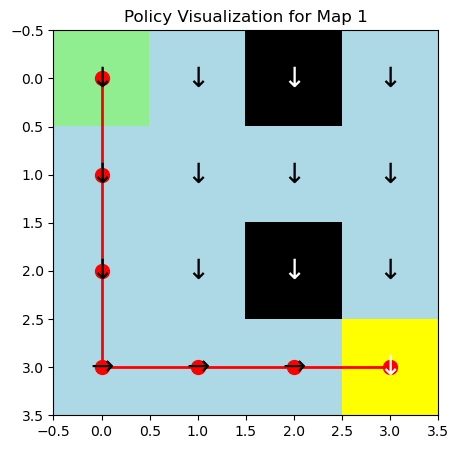

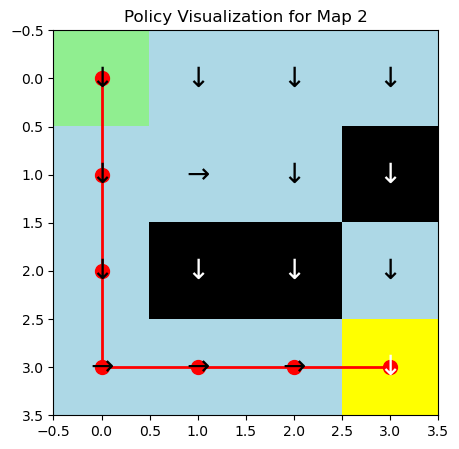

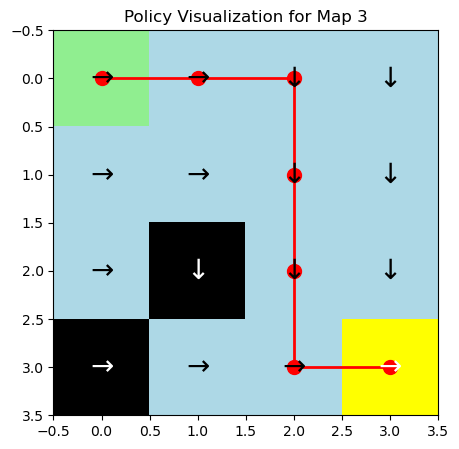

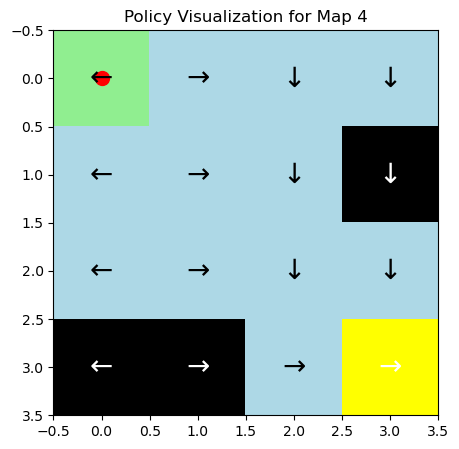

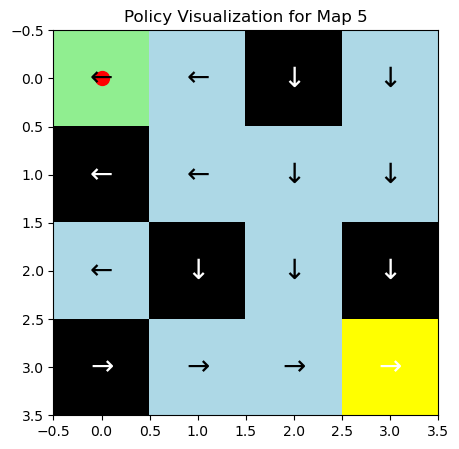

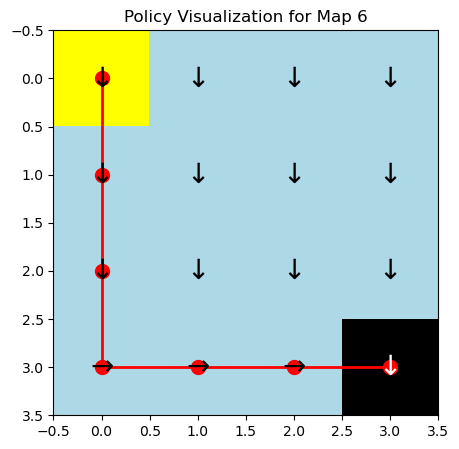

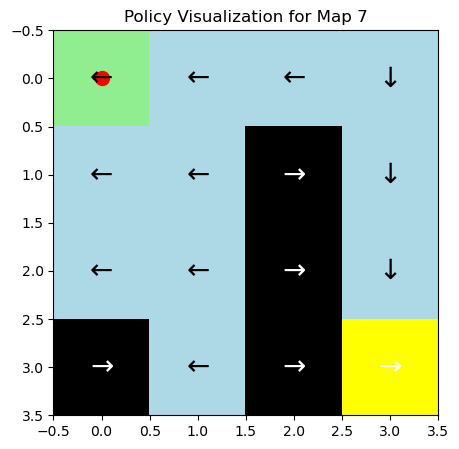

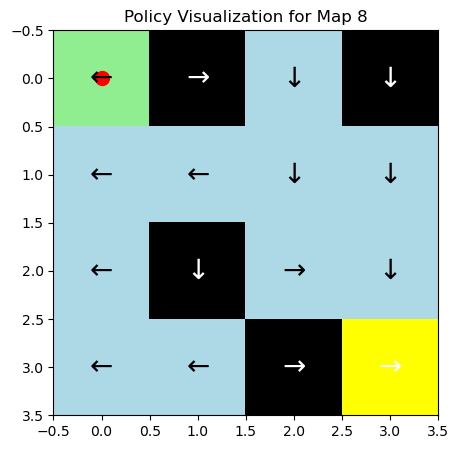

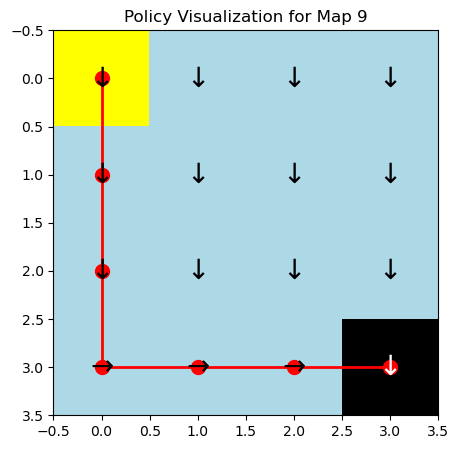

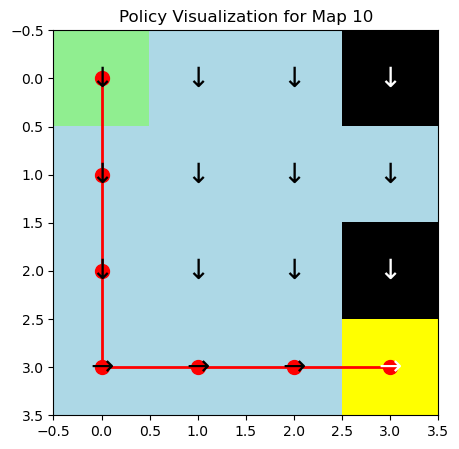

In [46]:
numerical_color_map = {'S': 1, 'F': 0, 'H': 3, 'G': 2}
def visualize_policy_on_random_maps(model, device, n_maps=5, n_states=16, is_slippery=False):
    for map_idx in range(n_maps):
        env = gym.make('FrozenLake-v1', desc=generate_random_map(size=4), is_slippery=is_slippery)
        desc = env.desc.astype(str)

        numerical_grid_colors = np.vectorize(numerical_color_map.get)(desc)

        state_tensors = [preprocess_state(state, env.desc).to(device) for state in range(n_states)]
        batch_states = torch.stack(state_tensors)
        policy_batch = torch.argmax(model(batch_states), dim=1).cpu().numpy()

        action_symbols = {0: '←', 1: '↓', 2: '→', 3: '↑'}
        policy_symbols = np.vectorize(action_symbols.get)(policy_batch)
        policy_grid = policy_symbols.reshape(env.desc.shape)

        plt.figure(figsize=(5, 5))
        cmap = ListedColormap(['lightblue', 'lightgreen', 'yellow', 'black'])
        plt.imshow(numerical_grid_colors, cmap=cmap, interpolation='nearest')

        # New: Trace the path
        current_position = np.where(desc == 'S')
        i, j = current_position[0][0], current_position[1][0]  # Extracting the start position
        path_x = [j]
        path_y = [i]

        while True:
            action = policy_grid[i, j]
            if action == '←': j -= 1 
            elif action == '→': j += 1
            elif action == '↑': i -= 1
            elif action == '↓': i += 1
            i = min(max(i, 0), desc.shape[0] - 1)  # Ensuring the agent doesn't go out of bounds
            j = min(max(j, 0), desc.shape[1] - 1)
            if (i, j) in zip(path_y, path_x):
                break
            path_x.append(j)
            path_y.append(i)
            if desc[i, j] in ['H', 'G']:
                break

        # Draw the path
        plt.plot(path_x, path_y, 'ro-', linewidth=2, markersize=10)

        for i in range(desc.shape[0]):
            for j in range(desc.shape[1]):
                arrow = policy_grid[i, j]
                arrow_color = 'white' if desc[i, j] in ['H', 'G'] else 'black'
                plt.text(j, i, policy_grid[i, j], ha='center', va='center', fontsize=20, color=arrow_color)

        plt.title(f'Policy Visualization for Map {map_idx+1}')
        plt.show()


visualize_policy_on_random_maps(model, device, n_maps=10, is_slippery=is_slippery)